### 自然语言处理的三种历史方法：

* 基于同义词词典的方法WordNet

问题：难以顺应时代变化，人力成本高，无法表示单词的微妙差异

* 基于计数的方法

语料库corpus处理。
word to id, id to word

* 基于推理的方法word2vec

In [4]:
# function to process word
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace(".", " .")
    words = text.split(" ")

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [5]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

分布式假设：某个单词的含义由他周围的单词表示。

窗口大小：上下文的大小。

共现矩阵co-accurence matrix：对单词周围的单词出现的次数进行统计，也是一种基于计数的方法。矩阵中每一个单词的向量，都是它周围的单词出现的次数，意味着，数字越高，同时出现的概率越大。

In [11]:
# create co-accurence matrix
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
        for i in range(1,  window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            if left_idx >= 0 :
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

In [20]:
word_matrix = create_co_matrix(corpus, len(id_to_word), 1)

向量间的相似度用**余弦相似度**cosine similarity,分子是向量的内积，分母是各个向量的范数。范数表示向量的大小，L2范数，是各个元素的平方和的平方根。

余弦相似度直观地表示了两个向量在多大程度上指向同一个方向。完全指向同一个方向为1，完全相反为-1.

In [27]:
def cos_similarity(x, y, eps=1e-8):
    # 正规化可以去除大小，保留向量方向，内积就是余弦夹角了, eps是一个微小值，防止除数为0
    nx = x / np.sqrt(np.sum(x**2) + eps) # x的正规化
    ny = y / np.sqrt(np.sum(y**2) + eps) # y的正规化
    return np.dot(nx, ny)

In [25]:
# 相似单词的top排序
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print(f"{query} is not found.")
        return
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    # calculate the co accurence
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    # output by the similarity
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f"{id_to_word[i]}:{similarity[i]}")
        count += 1
        if count >= top:
            return

In [26]:
most_similar("you", word_to_id, id_to_word, word_matrix, 5)

goodbye:0.7071067811865475
i:0.7071067811865475
hello:0.7071067811865475
say:0.0
and:0.0


**点互信息**：两个点的相关性。PMI，当其中一个单词的出现频率本来就很高的时候，就会拉低点互信息。这里为了防止负无穷，使用正点互信息。

In [28]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    print(f"{100*cnt/total:.1f}% done")
    return M

In [30]:
W = ppmi(word_matrix)

**降维**：将稀疏矩阵（大多数为0的矩阵）变为密集矩阵。奇异值SVD分解！

In [31]:
U, S, V = np.linalg.svd(W)

In [32]:
U[0]

array([-3.4094876e-01, -1.1102230e-16, -4.4408921e-16,  1.2051624e-01,
        9.3232495e-01,  0.0000000e+00,  3.2068993e-16], dtype=float32)

In [33]:
# 要降到二维，取出前两个元素即可
U[0, :2]

array([-3.4094876e-01, -1.1102230e-16], dtype=float32)

In [34]:
U

array([[-3.4094876e-01, -1.1102230e-16, -4.4408921e-16,  1.2051624e-01,
         9.3232495e-01,  0.0000000e+00,  3.2068993e-16],
       [ 0.0000000e+00, -5.9763640e-01,  1.8023790e-01,  0.0000000e+00,
         0.0000000e+00, -7.8124583e-01,  0.0000000e+00],
       [-4.3631220e-01, -5.5511151e-17, -2.2204460e-16,  5.0878286e-01,
        -2.2532563e-01, -1.3877788e-17, -7.0710677e-01],
       [-3.5786838e-16, -4.9782813e-01,  6.8039632e-01,  1.2400618e-16,
         8.1837114e-17,  5.3779924e-01, -8.8459581e-17],
       [-4.3631220e-01, -4.3286940e-17, -2.2171540e-16,  5.0878286e-01,
        -2.2532563e-01, -1.8037431e-17,  7.0710677e-01],
       [-7.0923710e-01, -4.3286940e-17, -2.2171540e-16, -6.8392676e-01,
        -1.7095888e-01, -1.8037431e-17, -1.0477132e-16],
       [ 4.8989860e-16, -6.2848860e-01, -7.1033454e-01, -1.7064894e-16,
        -2.2404199e-16,  3.1690210e-01,  1.1389929e-16]], dtype=float32)

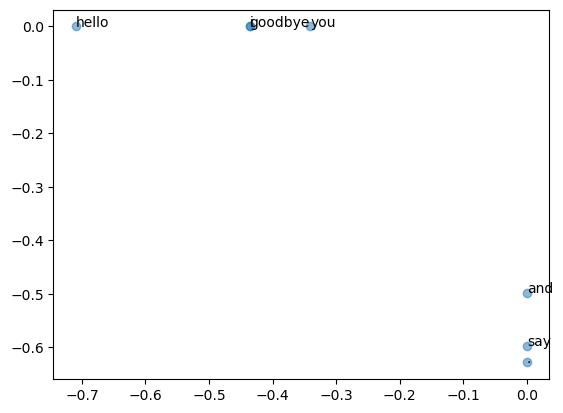

In [37]:
# 用二维向量表示各个单词，并画在图上
import matplotlib.pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### word2vec